# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from collections import Counter
import pickle 
import glob
import shutil
import os
import requests
import shutil
import urllib

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import imread, imshow, subplots, show
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

import pylab as pl

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim

from os import listdir
from os.path import isfile, join

from tqdm.auto import tqdm
import os
from PIL import Image
import cv2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

<ipython-input-1-48741e596def>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Preprocessing

In [3]:
with open('/content/drive/My Drive/Diploma/CODE/data/new_eng_data.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
df.columns

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration', 'actor',
       'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       'WORLD', 'element_id', 'rating', 'has_oscar_actor',
       'has_oscar_composer', 'has_oscar_design', 'has_oscar_director',
       'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer',
       'has_oscar_writer', 'poster_url', 'poster_url_preview', 'has_imax',
       'has_3_d', 'has_sequel'],
      dtype='object')

In [5]:
# add names of imgs

def add_img_name(data):
    return data.split('/')[-1]

df['img_name'] = df['poster_url_preview'].apply(add_img_name)

df.head().T[-5:]

,0,1,2,3,4
poster_url_preview,https://kinopoiskapiunofficial.tech/images/posters/kp_small/6580.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/6460.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/1228112.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/623934.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/1172958.jpg
has_imax,False,False,False,False,False
has_3_d,False,False,False,False,False
has_sequel,1,1,0,0,0
img_name,6580.jpg,6460.jpg,1228112.jpg,623934.jpg,1172958.jpg


In [6]:
import ast

columns = ['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
                      'OPERATOR', 'PRODUCER', 'WRITER', 'country', 'genre']
for col in columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if not isinstance(x, float) else np.nan)

In [7]:
cols_na = ['ACTOR', 'COMPOSER',
                 'DESIGN', 'DIRECTOR', 
                 'EDITOR', 'OPERATOR', 
                 'PRODUCER', 'WRITER']

df.dropna(subset=cols_na, inplace=True)

In [8]:
def add_topN_feature(df, col, n: int):
    items = []
    
    for i in df[col]:
        items.extend(i)

    topN = [x[0] for x in Counter(items).most_common()][:n]
    df[f'top{n}{col}'] = df[col].apply(lambda x: [int(item in x) for item in topN])
    df.drop(col, axis=1, inplace=True)
    return topN, f'top{n}{col}'

def ohe_topN_features(df, topN, cat):
    for i in range(len(topN)):
        df[f'{topN[i]}'] = [item[i] for item in df[cat]]
    df.drop(cat, axis=1, inplace=True)
    return df

In [9]:
top10genres, name = add_topN_feature(df, 'genre', 10)
df = ohe_topN_features(df, top10genres, name)

top10actors, name = add_topN_feature(df, 'ACTOR', 10)
df = ohe_topN_features(df, top10actors, name)

top3directors, name = add_topN_feature(df, 'COMPOSER', 3)
df = ohe_topN_features(df, top3directors, name)

top5countries, name = add_topN_feature(df, 'country', 5)
df = ohe_topN_features(df, top5countries, name)

top2DESIGN, name = add_topN_feature(df, 'DESIGN', 2)
df = ohe_topN_features(df, top2DESIGN, name)

top2DIRECTOR, name = add_topN_feature(df, 'DIRECTOR', 2)
df = ohe_topN_features(df, top2DIRECTOR, name)

top2EDITOR, name = add_topN_feature(df, 'EDITOR', 2)
df = ohe_topN_features(df, top2EDITOR, name)

top2OPERATOR, name = add_topN_feature(df, 'OPERATOR', 2)
df = ohe_topN_features(df, top2OPERATOR, name)

top3PRODUCER, name = add_topN_feature(df, 'PRODUCER', 3)
df = ohe_topN_features(df, top3PRODUCER, name)

top2WRITER, name = add_topN_feature(df, 'WRITER', 2)
df = ohe_topN_features(df, top2WRITER, name)

df.head().T

,0,1,4,5,6
age_access_type,12,16,6,16,12
name,Звёздный путь 5: Последний рубеж,Звёздный путь 6: Неоткрытая страна,Пламенное сердце,Роман с кукушкой,Звёздный путь 2: Гнев Хана
director,['cff3362f-ad91-498d-80b3-ea3ab8ec65cf'],['bab6b7f4-4506-458f-9091-d567505674f2'],"['40f78e6d-3c9f-434f-a505-c6ffdd045763', '332105c2-2697-49fd-97b2-b5022577758c']",['f5fba6fe-94b3-4e69-acfc-da6867320386'],['bab6b7f4-4506-458f-9091-d567505674f2']
average_rating,6.21,7.2,6.4,NaN,7.45
type,MOVIE,MOVIE,MOVIE,MOVIE,MOVIE
...,...,...,...,...,...
Харви Вайнштейн,0,0,0,0,0
Боб Вайнштейн,0,0,0,0,0
Арнон Милчен,0,0,0,0,0
Люк Бессон,0,0,0,0,0


In [10]:
prep_df = df.copy(deep=True)

In [11]:
skewed_num_features = ['duration', 'BUDGET', 'MARKETING',
                       'RUS', 'USA', 'WORLD']

In [12]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

class Preprocesser:
    def __init__(self, 
                skewed_num_features: list):
        self.skewed_num_features = skewed_num_features
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[col] = df_pr[col].apply(lambda x: self.tokenizer(x))
        return df_pr
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        
        return df_pr
        

In [13]:
preprocesser = Preprocesser(skewed_num_features )

In [14]:
df_pr = preprocesser.preprocess(prep_df)

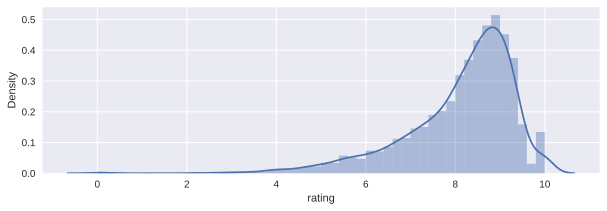

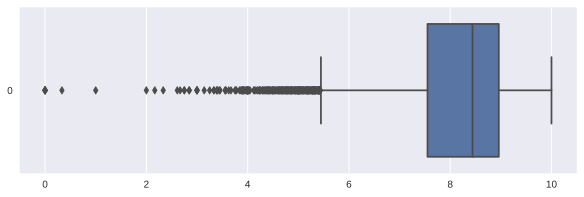

In [15]:
plt.figure(figsize=(10, 3))
sns.distplot(df_pr['rating'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(df_pr['rating'], orient='h')
plt.show()

### Test/Train split

In [16]:
train_df = df[df['release_year'] != 2021]

In [17]:
train_df.dropna(subset=['rating'], inplace=True)


In [18]:
test_df = df[df['release_year'] > 2020]


In [19]:
test_df.dropna(subset=['rating'], inplace=True)

### Preproc

In [20]:
train = train_df.copy(deep=True)
test = test_df.copy(deep=True)

In [21]:
train = train[train['release_year'] >= 2000]

In [22]:
train.columns[:30]

Index(['age_access_type', 'name', 'director', 'average_rating', 'type',
       'release_type', 'release_year', 'duration', 'actor', 'element_uid',
       'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD', 'element_id', 'rating',
       'has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
       'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
       'has_oscar_producer', 'has_oscar_writer', 'poster_url',
       'poster_url_preview', 'has_imax', 'has_3_d', 'has_sequel'],
      dtype='object')

In [23]:
train.columns[30:73]

Index(['img_name', 'Drama', 'Comedy', 'Thriller', 'Action',
       '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
       'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
       'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
       'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
       'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
       'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
       'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
       'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Арнон Милчен', 'Люк Бессон', 'Стэн Ли'],
      dtype='object')

In [24]:

drop_cols = ['name', 'director', 'average_rating', 'release_type', 'release_year', 'actor',
             'element_uid', 'element_id', 'poster_url', 'poster_url_preview']

In [25]:
train.drop(drop_cols, axis=1, inplace=True)

test.drop(drop_cols, axis=1, inplace=True)

In [26]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### ohe

In [27]:
from sklearn.preprocessing import OneHotEncoder

ohe_cols = ['age_access_type', 'type']

oenc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc_train = oenc.fit_transform(train[ohe_cols])

enc_train = pd.DataFrame(enc_train,columns=oenc.get_feature_names_out())

train = pd.concat([train, enc_train],axis=1)

train.drop(ohe_cols, axis=1, inplace=True)
# 
enc_test = oenc.transform(test[ohe_cols])

enc_test = pd.DataFrame(enc_test,columns=oenc.get_feature_names_out())

test = pd.concat([test, enc_test],axis=1) 

test.drop(ohe_cols, axis=1, inplace=True)

In [28]:
train.head().T[-50:]

,4,11,13,16,19
img_name,1172958.jpg,255129.jpg,888154.jpg,734349.jpg,321.jpg
Drama,0.0,0.0,0.0,0.0,0.0
Comedy,1.0,0.0,1.0,0.0,0.0
Thriller,0.0,1.0,0.0,1.0,1.0
Action,0.0,1.0,1.0,1.0,1.0
364fdc2e-bdfe-40be-b2c5-d30f43ec432e,0.0,0.0,0.0,0.0,0.0
Adventure,1.0,1.0,0.0,0.0,1.0
Sci-Fi,0.0,1.0,0.0,1.0,1.0
Melodrama,0.0,0.0,0.0,0.0,0.0
Horror,0.0,0.0,0.0,0.0,0.0


### Standartization

In [29]:
# sc

from sklearn.preprocessing import StandardScaler

sc_cols = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD']

sc=StandardScaler()
sc_train = sc.fit_transform(train[sc_cols])

sc_train = pd.DataFrame(sc_train,columns=sc_cols)
train.drop(sc_cols, axis=1, inplace=True)
train = pd.concat([train, sc_train],axis=1)

# 
sc_test = sc.transform(test[sc_cols])

sc_test = pd.DataFrame(sc_test,columns=sc_cols)
test.drop(sc_cols, axis=1, inplace=True)

test = pd.concat([test, sc_test],axis=1) 



In [30]:
train.head().T[-50:]

,4,11,13,16,19
Adventure,1.0,1.0,0.0,0.0,1.0
Sci-Fi,0.0,1.0,0.0,1.0,1.0
Melodrama,0.0,0.0,0.0,0.0,0.0
Horror,0.0,0.0,0.0,0.0,0.0
9fa28b61-a257-4a3e-945b-a9ef76a146d6,0.0,0.0,0.0,0.0,0.0
Бернард Коллако,0.0,0.0,0.0,0.0,0.0
Марк Фальво,0.0,0.0,0.0,0.0,0.0
Джимми Стар,0.0,0.0,0.0,0.0,0.0
Брюс Уиллис,0.0,0.0,0.0,0.0,0.0
Роджер Бреннер,0.0,0.0,0.0,0.0,0.0


In [31]:
fls = None 
for root_dir, cur_dir, files in os.walk(r'/content/drive/My Drive/Diploma/CODE/covers/'):
    fls = files
    

In [32]:
train_pr = train[train['img_name'].isin(fls)]

In [33]:
tst_fls = None 
for root_dir, cur_dir, files in os.walk(r'/content/drive/My Drive/Diploma/CODE/covers/'):
    tst_fls = files

In [34]:
test_pr = test[test['img_name'].isin(tst_fls)]

In [35]:
# fls = None 
# for root_dir, cur_dir, files in os.walk(r'/content/drive/My Drive/Diploma/CODE/train_cvrs/'):
#     fls = files
    
# len(fls)

In [36]:
# print(train.shape)
# train_pr = train[train['img_name'].isin(fls)]
# train_pr.shape

In [37]:
# tst_fls = None 
# for root_dir, cur_dir, files in os.walk(r'/content/drive/My Drive/Diploma/CODE/test_covers/'):
#     tst_fls = files

In [38]:
# len(tst_fls)

In [39]:
# print(test.shape)
# test_pr = test[test['img_name'].isin(tst_fls)]
# test_pr.shape

**Save preproc dfs**

In [40]:


# with open('/root/User/_DIPLOMA/data/preproc_dfs/train_pr_oscr_ohe_new.pkl', 'wb') as f:
#     pickle.dump(train_pr, f)

# with open('/root/User/_DIPLOMA/data/preproc_dfs/test_pr_oscr_ohe_new.pkl', 'wb') as f:
#     pickle.dump(test_pr, f)

**Load datasets**

In [41]:
# with open('/root/User/_DIPLOMA/data/preproc_dfs/train_pr_oscr_ohe_new.pkl', 'rb') as f:
#     train_pr = pickle.load(f, encoding='utf-8')

In [42]:
# with open('/root/User/_DIPLOMA/data/preproc_dfs/test_pr_oscr_ohe_new.pkl', 'rb') as f:
#     test_pr = pickle.load(f, encoding='utf-8')

In [36]:
test_pr.head().T

,4,5,13,26,46
rating,9.282869,7.720848,8.9459,8.124109,8.626496
has_oscar_actor,0.0,0.0,0.0,0.0,0.0
has_oscar_composer,0.0,0.0,0.0,0.0,0.0
has_oscar_design,0.0,0.0,0.0,0.0,0.0
has_oscar_director,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
BUDGET,-0.72813,NaN,NaN,NaN,NaN
MARKETING,NaN,NaN,NaN,NaN,NaN
RUS,NaN,NaN,-0.369808,NaN,NaN
USA,NaN,-0.62073,-0.605231,NaN,NaN


In [37]:
test_pr.columns

Index(['rating', 'has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
       'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
       'has_oscar_producer', 'has_oscar_writer', 'has_imax', 'has_3_d',
       'has_sequel', 'img_name', 'Drama', 'Comedy', 'Thriller', 'Action',
       '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
       'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
       'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
       'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
       'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
       'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
       'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
       'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Арнон Милчен', 'Люк Бессон', 'Стэн Ли', 'age_access_type_0',
       'age_

In [38]:
train_pr.isna().sum()[50:100]

Боб Вайнштейн            0
Арнон Милчен             0
Люк Бессон               0
Стэн Ли                  0
age_access_type_0     1716
age_access_type_6     1716
age_access_type_12    1716
age_access_type_16    1716
age_access_type_18    1716
type_MOVIE            1716
type_MP_MOVIE         1716
type_SERIAL           1716
duration              1716
BUDGET                3189
MARKETING             4433
RUS                   3087
USA                   3004
WORLD                 2482
dtype: int64

In [39]:
test_pr.isna().sum()[50:100]

Боб Вайнштейн           0
Арнон Милчен            0
Люк Бессон              0
Стэн Ли                 0
age_access_type_0     316
age_access_type_6     316
age_access_type_12    316
age_access_type_16    316
age_access_type_18    316
type_MOVIE            316
type_MP_MOVIE         316
type_SERIAL           316
duration              316
BUDGET                323
MARKETING             326
RUS                   322
USA                   321
WORLD                 320
dtype: int64

In [40]:
cols_dropna = ['age_access_type_0', 
              'age_access_type_6',     
              'age_access_type_12',    
              'age_access_type_16' ,   
              'age_access_type_18' ,   
              'type_MOVIE'  ,        
              'type_MP_MOVIE' ,        
              'type_SERIAL' ,'duration', 
               'USA', 'WORLD']  

train_pr.dropna(subset=cols_dropna,  inplace=True)
test_pr.dropna(subset=cols_dropna,  inplace=True)

In [41]:
train_new = train_pr.drop([
'BUDGET',
'MARKETING',
'RUS',
'img_name',
'rating'], axis=1)

test_new = test_pr.drop([
'BUDGET',
'MARKETING',
'RUS',
'img_name',
'rating'], axis=1)

In [42]:
train_img = train_pr[['img_name']]

test_img = test_pr[['img_name']]

y_train = train_pr[['rating']]
y_test = test_pr[['rating']]

In [43]:
train_new.columns

Index(['has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
       'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
       'has_oscar_producer', 'has_oscar_writer', 'has_imax', 'has_3_d',
       'has_sequel', 'Drama', 'Comedy', 'Thriller', 'Action',
       '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
       'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
       'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
       'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
       'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
       'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
       'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
       'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Арнон Милчен', 'Люк Бессон', 'Стэн Ли', 'age_access_type_0',
       'age_access_type_6', 'age_a

# Remove outliers

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn import model_selection
import warnings
warnings.filterwarnings("ignore")

In [ ]:
model = IsolationForest(random_state=47)

param_grid = {'n_estimators': [1000, 1500], 
              'max_samples': [10], 
              'contamination': ['auto', 0.0001, 0.0002], 
              'max_features': [10, 15], 
              'bootstrap': [True], 
              'n_jobs': [-1]}

grid_search = model_selection.GridSearchCV(model, 
                                           param_grid,
                                           scoring="neg_mean_squared_error", 
                                           refit=True,
                                           cv=10, 
                                           return_train_score=True)
grid_search.fit(train_new, y_train)

best_model = grid_search.fit(train_new, y_train)
print('Optimum parameters', best_model.best_params_)

Optimum parameters {'bootstrap': True, 'contamination': 0.0001, 'max_features': 10, 'max_samples': 10, 'n_estimators': 1000, 'n_jobs': -1}


In [45]:
iforest = IsolationForest(bootstrap=True,
                          contamination=0.0001, 
                          max_features=10, 
                          max_samples=10, 
                          n_estimators=1000, 
                          n_jobs=-1,
                         random_state=1)
y_pred = iforest.fit_predict(train_new)

**Remove the outliers**

In [46]:
train_new['TARGET'] = y_train.values
train_new['PREDS'] = y_pred.tolist()

In [47]:
train_new['img_name'] = train_img.values
test_new['img_name'] = test_img.values

train_new['rating'] = y_train
test_new['rating'] = y_test

In [48]:
train_new = train_new[train_new['PREDS'] == 1]

In [49]:
train_new.drop(['TARGET', 'PREDS'], axis=1, inplace=True)

In [50]:
train_new.columns

Index(['has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
       'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
       'has_oscar_producer', 'has_oscar_writer', 'has_imax', 'has_3_d',
       'has_sequel', 'Drama', 'Comedy', 'Thriller', 'Action',
       '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
       'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
       'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
       'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
       'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
       'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
       'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
       'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Арнон Милчен', 'Люк Бессон', 'Стэн Ли', 'age_access_type_0',
       'age_access_type_6', 'age_a

# PyTorch

In [58]:
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

data_path = "./data/"

In [59]:
class ImageDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, df, image_dir):
        self.image_dir = image_dir
        self.tabular = df 
        self.RESCALE_SIZE = 128

    def __len__(self):
        return self.tabular.shape[0]
    def _prepare_sample(self, image):

        image = image.resize((self.RESCALE_SIZE, self.RESCALE_SIZE))
        return np.array(image)

    def __getitem__(self, idx):
        tabular = self.tabular.iloc[idx, 0:]

        y = tabular["rating"]

        image = Image.open(f"{self.image_dir}/{tabular['img_name']}").convert('RGB')
        image.load()
        image = self._prepare_sample(image)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        image = np.array(image / 255, dtype='float32')
        image = transform(image)

        tabular = tabular[['duration', 'USA', 'WORLD', 'has_oscar_actor', 'has_oscar_composer',
       'has_oscar_design', 'has_oscar_director', 'has_oscar_editor',
       'has_oscar_operator', 'has_oscar_producer', 'has_oscar_writer',
       'has_imax', 'has_3_d', 'has_sequel', 'Drama', 'Comedy', 'Thriller',
       'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
       'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
       'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
       'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
       'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
       'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
       'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
       'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Арнон Милчен', 'Люк Бессон', 'Стэн Ли', 'age_access_type_0', 
              'age_access_type_6',     
              'age_access_type_12',    
              'age_access_type_16' ,   
              'age_access_type_18' ,   
              'type_MOVIE'  ,        
              'type_MP_MOVIE' ,        
              'type_SERIAL' ]]
        tabular = tabular.tolist()
        tabular = torch.FloatTensor(tabular)

        return image, tabular, y

In [60]:
a = ['duration', 'USA', 'WORLD', 'has_oscar_actor', 'has_oscar_composer',
       'has_oscar_design', 'has_oscar_director', 'has_oscar_editor',
       'has_oscar_operator', 'has_oscar_producer', 'has_oscar_writer',
       'has_imax', 'has_3_d', 'has_sequel', 'Drama', 'Comedy', 'Thriller',
       'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
       'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
       'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
       'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
       'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
       'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
       'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
       'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Арнон Милчен', 'Люк Бессон', 'Стэн Ли', 'x0_0', 'x0_6', 'x0_12',
       'x0_16', 'x0_18', 'x1_MOVIE', 'x1_MP_MOVIE', 'x1_SERIAL']

len(a)

63

## Model

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cuda


In [64]:
image_data_train = ImageDataset(df=train_new, image_dir='/content/drive/My Drive/Diploma/CODE/covers/')

test_set = ImageDataset(df=test_new, image_dir='/content/drive/My Drive/Diploma/CODE/covers')

train_set, test_dddd, val_set = random_split(image_data_train, [1300, 0, 257])

In [65]:
BATCH_SIZE = 10

In [66]:
train_loader = DataLoader(
    train_set, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_set, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_set, 
    batch_size=BATCH_SIZE,
    shuffle=True
)


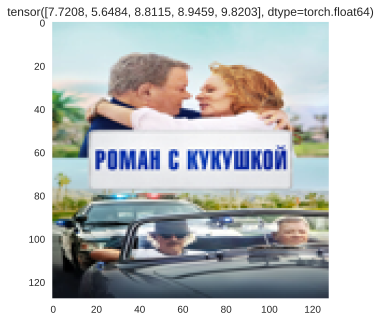

In [67]:
def imshow(inp, title=None, default=False):
    """Imshow для тензоров"""
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    
    inp = inp[0].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    a.imshow(inp)
    if title is not None:
        a.set_title(title)
    a.grid(False)


for im_val, tab, label in test_loader:
  imshow(im_val.data.cpu(), \
        title=label)
  break


## RESNET50

In [52]:
import torchvision.models as models
from torchsummary import summary

In [101]:
resnet50 = models.resnet18(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


**Freezed layers**

Change output layer

In [108]:
class RatingPredictor(nn.Module):
    def __init__(self):
        super().__init__()

        
        resnet50.fc = nn.Linear(in_features=512, out_features=32)
        resnet50.fc.requires_grad_(True)
        self.resnet = resnet50
        # mobilenet_ft.fc = nn.Linear(in_features=128, out_features=32)
        # mobilenet_ft.fc.requires_grad_(True)
        # self.resnet = mobilenet_ft

        self.ln4 = nn.Linear(63, 16)
        self.relu1 = nn.ReLU()
        self.ln5 = nn.Linear(16, 3)
        self.relu2 = nn.ReLU()
        # self.ln6 = nn.Linear(16, 5)
        # self.relu3 = nn.ReLU()
        self.ln7 = nn.Linear(35, 1)
        self.relu4 = nn.ReLU()

    def forward(self, img, tab):
        img = self.resnet(img)
        # print(f'img: {img.shape}')
        img = img.reshape(img.shape[0], -1)
        # print(f'img: {img.shape}')

        tab = self.ln4(tab)
        tab = self.relu1(tab)
        tab = self.ln5(tab)
        tab = self.relu2(tab)
        # tab = self.ln6(tab)
        # tab = self.relu3(tab)
        # print(f'tab: {tab.shape}')
        x = torch.cat((img, tab), dim=1)
        # print(f'X SHAPE: {x.shape}')
        x = self.relu4(x)

        return self.ln7(x)
    
    def training_step(self, batch):
        inputs, tabular, targets = batch 
        inputs = inputs.cuda() 
        tabular = tabular.cuda() 
        targets = targets.cuda() 

        # Generate predictions
        out = self(inputs, tabular)       
        # Calcuate loss
        loss = F.l1_loss(out, targets)                
        return loss

    def validation_step(self, batch):
        inputs, tabular, targets = batch
        inputs = inputs.cuda() 
        tabular = tabular.cuda() 
        targets = targets.cuda() 

        # Generate predictions
        out = self(inputs, tabular)
        # Calculate loss
        loss = F.l1_loss(out, targets) 
        acc = accuracy(out,targets)                   
        return {'val_loss': loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accuracy = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}

  
    def epoch_end(self, epoch, result, num_epochs):
      if (epoch+1) % 10 == 0 or epoch == num_epochs-1:
        print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

**Train**

In [126]:
criterion = nn.L1Loss()

# Hyper parameters
learning_rate = 0.0001 

# Adam Optimizer
optimizer = torch.optim.AdamW(resnet50.parameters(), lr=learning_rate)
# ls_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

model_res = RatingPredictor().to(device)

In [72]:
def accuracy(output,labels):
    _,preds =torch.max(output,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [73]:
def evaluate(model, val_loader):
    model.eval() #
    with torch.no_grad(): #
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)

def train(epochs, lr, model, train_loader, val_loader, optimizer, ls_scheduler=None):  # train
    history = []
    # optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() #
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            # ls_scheduler.step()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)

    return history

In [129]:
history = [evaluate(model_res, val_loader)]
print(history)

[{'val_loss': 8.534121801785334, 'val_acc': 0.0}]


In [130]:
epochs = 500

history += train(epochs, learning_rate, model_res, 
                 train_loader, val_loader, optimizer)

Epoch [10], val_loss: 4.3431
Epoch [20], val_loss: 3.4956
Epoch [30], val_loss: 2.5916
Epoch [40], val_loss: 2.2916
Epoch [50], val_loss: 1.3217
Epoch [60], val_loss: 0.9993
Epoch [70], val_loss: 1.3264
Epoch [80], val_loss: 1.1467
Epoch [90], val_loss: 1.4972
Epoch [100], val_loss: 1.0443
Epoch [110], val_loss: 1.8028
Epoch [120], val_loss: 1.1494
Epoch [130], val_loss: 1.2653
Epoch [140], val_loss: 1.4137
Epoch [150], val_loss: 1.1690
Epoch [160], val_loss: 1.5339
Epoch [170], val_loss: 1.8510
Epoch [180], val_loss: 1.3015
Epoch [190], val_loss: 1.4508
Epoch [200], val_loss: 1.6631
Epoch [210], val_loss: 1.3459
Epoch [220], val_loss: 1.2889
Epoch [230], val_loss: 1.2345
Epoch [240], val_loss: 1.0275
Epoch [250], val_loss: 1.0679
Epoch [260], val_loss: 1.0549
Epoch [270], val_loss: 1.2045
Epoch [280], val_loss: 1.0737
Epoch [290], val_loss: 0.9477
Epoch [300], val_loss: 1.2085
Epoch [310], val_loss: 1.1255
Epoch [320], val_loss: 0.9536
Epoch [330], val_loss: 1.0493
Epoch [340], val_lo

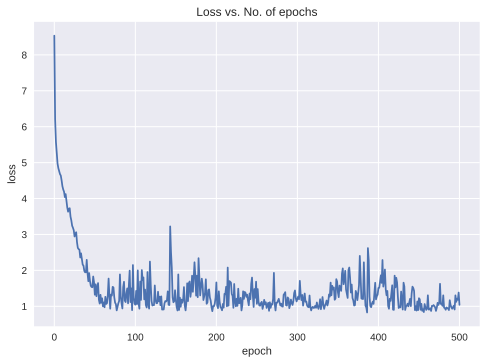

In [131]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [132]:
test_imgs, test_tabular, test_lbls = next(iter(test_loader))
test_imgs = test_imgs.cuda()
test_tabular = test_tabular.cuda()
test_lbls = test_lbls.cuda()

with torch.no_grad(): 
    preds = model_res(test_imgs, test_tabular)

In [133]:
yhat=preds.flatten().to('cpu')
yhat

tensor([9.5508, 8.2605, 8.6392, 8.2382, 8.2772])

In [53]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_errors_and_r2(y_true, y_pred):
    mean_squared_err = (mean_squared_error(y_true, y_pred))
    root_mean_squared_err = np.sqrt(mean_squared_err)
    mae = (mean_absolute_error(y_true, y_pred))
    r2 = round(r2_score(y_true, y_pred)*100,0)
    return mean_squared_err, root_mean_squared_err, mae, r2

In [135]:
test_mean_squared_error, test_root_mean_squared_error,test_mae, test_r2_score_percentage = calculate_errors_and_r2(test_lbls.to('cpu'), yhat)

print('Test Data MSE = ', test_mean_squared_error)
print('Test Data RMSE = ', test_root_mean_squared_error)
print('Test Data MAE = ', test_mae)
print('Test Data R2 = ', test_r2_score_percentage)

Test Data MSE =  2.4526946349819414
Test Data RMSE =  1.5661081172709441
Test Data MAE =  1.241456857866599
Test Data R2 =  -19.0


In [136]:
torch.save(model_res.state_dict(), '/content/drive/My Drive/Diploma/CODE/data/models/model_resnet18_v1.pth')

## mobilenet

In [68]:
mobilenet_ft = models.mobilenet_v3_large(pretrained=True).to(device)

In [94]:
class RatingPredictor(nn.Module):
    def __init__(self):
        super().__init__()

        mobilenet_ft.fc = nn.Linear(in_features=128, out_features=32)
        mobilenet_ft.fc.requires_grad_(True)
        self.mobilenet = mobilenet_ft

        self.ln4 = nn.Linear(63, 10)
        self.relu1 = nn.ReLU()
        self.ln5 = nn.Linear(10, 5)
        self.relu2 = nn.ReLU()
        self.ln7 = nn.Linear(1005, 1)
        self.relu4 = nn.ReLU()

    def forward(self, img, tab):
        img = self.mobilenet(img)
        img = img.reshape(img.shape[0], -1)
        # print(f'img: {img.shape}')

        tab = self.ln4(tab)
        tab = self.relu1(tab)
        tab = self.ln5(tab)
        tab = self.relu2(tab)
        # print(f'tab: {tab.shape}')
        x = torch.cat((img, tab), dim=1)
        x = self.relu4(x)

        return self.ln7(x)
    
    def training_step(self, batch):
        inputs, tabular, targets = batch 
        inputs = inputs.cuda() 
        tabular = tabular.cuda() 
        targets = targets.cuda() 

        # Generate predictions
        out = self(inputs, tabular)       
        # Calcuate loss
        loss = F.l1_loss(out, targets)                
        return loss

    def validation_step(self, batch):
        inputs, tabular, targets = batch
        inputs = inputs.cuda() 
        tabular = tabular.cuda() 
        targets = targets.cuda() 

        # Generate predictions
        out = self(inputs, tabular)
        # Calculate loss
        loss = F.l1_loss(out, targets) 
        acc = accuracy(out,targets)                   
        return {'val_loss': loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accuracy = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}

  
    def epoch_end(self, epoch, result, num_epochs):
      if (epoch+1) % 10 == 0 or epoch == num_epochs-1:
        print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

In [109]:
criterion = nn.L1Loss()

# Hyper parameters
learning_rate = 0.001 

# Adam Optimizer
optimizer = torch.optim.AdamW(mobilenet_ft.parameters(), lr=learning_rate)
# ls_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

model_mobilenet = RatingPredictor().to(device)

In [110]:
history = [evaluate(model_mobilenet, val_loader)]
print(history)

[{'val_loss': 8.231530015379242, 'val_acc': 0.007692307699471712}]


In [111]:
epochs = 100

history += train(epochs, learning_rate, model_mobilenet, 
                 train_loader, val_loader, optimizer)

Epoch [10], val_loss: 1.6482
Epoch [20], val_loss: 1.6139
Epoch [30], val_loss: 1.5686
Epoch [40], val_loss: 1.5553
Epoch [50], val_loss: 1.6101
Epoch [60], val_loss: 1.5172
Epoch [70], val_loss: 1.6209
Epoch [80], val_loss: 1.7291
Epoch [90], val_loss: 1.5858
Epoch [100], val_loss: 1.7427


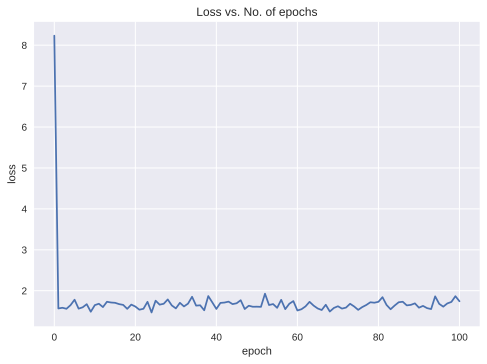

In [112]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [113]:
test_imgs, test_tabular, test_lbls = next(iter(test_loader))
test_imgs = test_imgs.cuda()
test_tabular = test_tabular.cuda()
test_lbls = test_lbls.cuda()

with torch.no_grad(): 
    preds = model_mobilenet(test_imgs, test_tabular)

In [114]:
yhat=preds.flatten().to('cpu')

In [89]:
test_mean_squared_error, test_root_mean_squared_error,test_mae, test_r2_score_percentage = calculate_errors_and_r2(test_lbls.to('cpu'), yhat)

print('Test Data MSE = ', test_mean_squared_error)
print('Test Data RMSE = ', test_root_mean_squared_error)
print('Test Data MAE = ', test_mae)
print('Test Data R2 = ', test_r2_score_percentage)

Test Data MSE =  2.424138253068988
Test Data RMSE =  1.5569644353898993
Test Data MAE =  1.082971827777035
Test Data R2 =  -18.0


In [ ]:
torch.save(model_res.state_dict(), '/content/drive/My Drive/Diploma/CODE/data/models/model_mobilenet_v1.pth')